# Load libraries and data

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

# Display up to 100 rows of data
pd.options.display.min_rows = 100

data = pd.read_csv('../data/Merged_Df_Cleaned_Enhanced 2.csv')

data.head()

,Show,Season,Episode,Time,Episode Length,IMDB Rating,Emmy Nominations,Emmy Wins,Air Date,SD_div_mean_2,...,Network_HBO (US),Network_IFC,Network_NBC,Network_Paramount Network,Network_Showtime,Network_Starz,Network_The CW,Network_The WB,Network_USA Network,Cancelled
0,2 Broke Girls,1,1,9:30 PM,22,7.3,NaN,NaN,9/19/2011,9159.676336,...,0,0,0,0,0,0,0,0,0,1
1,2 Broke Girls,1,2,8:30 PM,22,7.1,NaN,NaN,9/26/2011,3451.804293,...,0,0,0,0,0,0,0,0,0,1
2,2 Broke Girls,1,3,8:30 PM,22,7.2,NaN,NaN,10/3/2011,3977.461758,...,0,0,0,0,0,0,0,0,0,1
3,2 Broke Girls,1,4,8:30 PM,22,7.3,NaN,NaN,10/10/2011,7097.733100,...,0,0,0,0,0,0,0,0,0,1
4,2 Broke Girls,1,6,8:30 PM,22,7.2,NaN,NaN,10/24/2011,5883.807213,...,0,0,0,0,0,0,0,0,0,1


For each show, each episode we have sentiment analysis metrics + viewership (millions) of the debut release.
Each measure appears 3 times corresponding to different acts within an episode. We have 129 measures from the sentiment analysis output / 3 acts correspond to **43 emotions per act**.

***NLP Dictionary***:
- Sd_div_mean: Aims to assess how quickly a consumer becomes immersed in a story—both mentally and emotionally. Become absorbed in the narrative. By dividing the standard deviation of overall emotion scores by the mean, this measurement captures the shifts, variability, and intensity of emotions throughout the experience.
- Sd_sum: Sum of the standard deviation, amount of emotion variance for each act.
- Sd_scaled: Standard deviation scaled across all emotions for ease of comparison.
- Anger
- Surprise
- Disgust
- Sadness
- Neutral
- Fear
- Joy
- Positive
- Negative
- Engaged: High ssychological involvement or emotional investment, including greater use of personal pronouns, more emotional words, and greater cognitive processing contained in the act.
- Not Engaged: Low psychological involvement or emotional investment, including lesser use of personal pronouns, less emotional words, and less cognitive processing contained in the act.
- WC: Total word count contained in the act.
- Analytic: Analytical, formal, or logical discussion contained in the act.
- Clout: Social status, confidence, or leadership discussion contained in the act.
- Authenticity: Honest, non-filtered, non-regulated discussion contained in the act.
- Tone: The higher the tone, the more positive the tone in the act (below 50 is considered negative).
- WPS: Average words per sentence.
- Six letter: Percentage of words longer than six letters.
- Dic: Percentage of words that were captured as dictionary words.
- Cogprocess: An aggregate measurement that looks at the amount of words that reflect active information processing and mental activities, including causation contained in the act.
    - Insight: Considers realizations.
    - Cause: Examines causation between two elements.
    - Discrep: Considers what should, could, or would have happened, but never did, (exploring counterfactuals).
    - Tentative: Looks at whether something could or could not happen (e.g. maybe, perhaps).
    - Certain: Looks at absolute language (e.g. always, never).
    - Differ (Is this differentiate?): Considers differentiation between two elements such as (hasn’t , but, else).
- Perceptual: An aggregate measurement of terms that describe perception, such as look, heard, and feeling.
    - See: Amount of text around viewing or seeing.
    - Hear: Amount of text around hearing or listening.
    - Feel: Looks at references to touch or feeling.
- Drives: An aggregate measurement that looks at different motivations.
    - Affiliation: Looks at relations and affiliations such as ally, friend, or being social.
    - Achieve: Considers the ability to win, earn success, and be better.
    - Power: Examines power dynamics and structures including superiority and bullying.
    - Reward: Examines the types of rewards that are discussed including receiving something, prizes, and benefits.
    - Risk: Examines the different types of dangers and doubts.
- Relativity: Aggregate measure extends toward spatial relationships such as area, bend, and exit.
    - Motion: Examines the ability to move, including arrive, car, and go.
    - Space: Examines directions in space, including down, and in.
    - Time: Examines time durations, including end, until and season.


# New Variables

In [4]:
# Impact of first or last episodes vs mid-season
data['is_season_premiere'] = data.groupby(['Show','Season'])['Episode'].rank() == 1
data['is_season_finale'] = data.groupby(['Show','Season'])['Episode'].rank(ascending = False) == 1

def classify_episode(row):
    if row['is_season_premiere']:
        return 'Season Premiere'
    elif row['is_season_finale']:
        return 'Season Finale'
    else:
        return 'Regular Episode'
data['Episode Type'] = data.apply(classify_episode, axis=1)

# Air date variables
# Convert AirDate to date format
data['Air Date'] = pd.to_datetime(data['Air Date'])

# Extract month, year, day of the week, and season
data['month'] = data['Air Date'].dt.month
data['year'] = data['Air Date'].dt.year
data['year_month'] = data['Air Date'].dt.to_period('M')
data['day_of_week'] = data['Air Date'].dt.day_name()
data['season'] = data['Air Date'].dt.month % 12 // 3 + 1  # 1=Winter, 2=Spring, etc.
data['season'] = data['Air Date'].dt.month % 12 // 3 + 1  # 1=Winter, 2=Spring, etc.
data['year_season'] = data['Air Date'].dt.year.astype(str) + "_0" + data['season'].astype(str)

data[['Air Date', 'month', 'year_month', 'year', 'day_of_week', 'season', 'year_season']].head()

# Viewership lag variables
data['vw_prev'] = data.groupby(['Show', 'Season'])['Viewership (millions)'].diff()
# Moving avg of 3 episodes
data['moving_avg_vw'] = data.groupby(['Show', 'Season'])['Viewership (millions)'].rolling(window=3, min_periods=1).mean().reset_index(drop = True)
data.head()

,Show,Season,Episode,Time,Episode Length,IMDB Rating,Emmy Nominations,Emmy Wins,Air Date,SD_div_mean_2,...,is_season_finale,Episode Type,month,year,year_month,day_of_week,season,year_season,vw_prev,moving_avg_vw
0,2 Broke Girls,1,1,9:30 PM,22,7.3,NaN,NaN,2011-09-19,9159.676336,...,False,Season Premiere,9,2011,2011-09,Monday,4,2011_04,NaN,19.370000
1,2 Broke Girls,1,2,8:30 PM,22,7.1,NaN,NaN,2011-09-26,3451.804293,...,False,Regular Episode,9,2011,2011-09,Monday,4,2011_04,-7.62,15.560000
2,2 Broke Girls,1,3,8:30 PM,22,7.2,NaN,NaN,2011-10-03,3977.461758,...,False,Regular Episode,10,2011,2011-10,Monday,4,2011_04,-0.33,14.180000
3,2 Broke Girls,1,4,8:30 PM,22,7.3,NaN,NaN,2011-10-10,7097.733100,...,False,Regular Episode,10,2011,2011-10,Monday,4,2011_04,-0.71,11.293333
4,2 Broke Girls,1,6,8:30 PM,22,7.2,NaN,NaN,2011-10-24,5883.807213,...,False,Regular Episode,10,2011,2011-10,Monday,4,2011_04,0.48,11.106667


# Cleaning

In [7]:
# The flinstones Air Date is 2065
print(data[data.year > 2024].head())

# Filter out these records
data = data[data.year <= 2024]

                  Show  Season  Episode     Time  Episode Length  IMDB Rating  \
21107  The Flintstones       5        1  8:30 PM              22          NaN   
21108  The Flintstones       5        2  8:30 PM              22          NaN   
21109  The Flintstones       5        3  8:30 PM              22          NaN   
21110  The Flintstones       5        4  8:30 PM              22          NaN   
21111  The Flintstones       5        5  8:30 PM              22          NaN   

       Emmy Nominations  Emmy Wins    Air Date  SD_div_mean_2  ...  \
21107               NaN         NaN 2064-09-17    6372.229734  ...   
21108               NaN         NaN 2064-09-24    3258.085274  ...   
21109               NaN         NaN 2064-10-01    5583.434740  ...   
21110               NaN         NaN 2064-10-08    3963.989606  ...   
21111               NaN         NaN 2064-10-15    3394.029156  ...   

       is_season_finale     Episode Type  month  year  year_month  \
21107             False

# Exploring

In [10]:
len(data.Show.unique())

218

In [12]:
data.head()

,Show,Season,Episode,Time,Episode Length,IMDB Rating,Emmy Nominations,Emmy Wins,Air Date,SD_div_mean_2,...,is_season_finale,Episode Type,month,year,year_month,day_of_week,season,year_season,vw_prev,moving_avg_vw
0,2 Broke Girls,1,1,9:30 PM,22,7.3,NaN,NaN,2011-09-19,9159.676336,...,False,Season Premiere,9,2011,2011-09,Monday,4,2011_04,NaN,19.370000
1,2 Broke Girls,1,2,8:30 PM,22,7.1,NaN,NaN,2011-09-26,3451.804293,...,False,Regular Episode,9,2011,2011-09,Monday,4,2011_04,-7.62,15.560000
2,2 Broke Girls,1,3,8:30 PM,22,7.2,NaN,NaN,2011-10-03,3977.461758,...,False,Regular Episode,10,2011,2011-10,Monday,4,2011_04,-0.33,14.180000
3,2 Broke Girls,1,4,8:30 PM,22,7.3,NaN,NaN,2011-10-10,7097.733100,...,False,Regular Episode,10,2011,2011-10,Monday,4,2011_04,-0.71,11.293333
4,2 Broke Girls,1,6,8:30 PM,22,7.2,NaN,NaN,2011-10-24,5883.807213,...,False,Regular Episode,10,2011,2011-10,Monday,4,2011_04,0.48,11.106667


In [14]:
data.groupby('Cancelled')['Show'].nunique()

Cancelled
0    144
1     47
2     27
Name: Show, dtype: int64

235 Shows. 

In [16]:
# Filter Shows based on minimum number of episodes threshold
min_episodes_threshold = 10  # Adjust as needed

# Number of episodes per show
episode_counts = data.groupby('Show').size()
episode_counts[episode_counts <= min_episodes_threshold].index

Index([], dtype='object', name='Show')

No shows have less than 10 episodes.

In [19]:
# Check missing values
data.isna().sum().sort_values(ascending = False).head(5)

Emmy Nominations    25232
Emmy Wins           25232
IMDB Rating         25212
vw_prev              1393
Show                    0
dtype: int64

In [21]:
# Display a statistical summary of the 'Viewership (millions)' column
data['Viewership (millions)'].describe().T

count    25232.000000
mean        10.656791
std          7.785822
min          0.049000
25%          4.840000
50%          9.110000
75%         14.840000
max         58.530000
Name: Viewership (millions), dtype: float64

In [23]:
# Many genres
data['Genre'].unique()

array(['Sitcom', 'Serial drama', 'Procedural drama', 'Family drama',
       'Mockumentary', 'Science fantasy', 'Comedy-Drama',
       'Animated sitcom', 'Superhero', 'Black comedy', 'Crime drama',
       'Drama', 'Police procedural', 'Medical drama', 'Legal drama',
       'Supernatural', 'Crime', 'Mystery', 'Action', 'Western',
       'Political thriller', 'Comedy', 'Musical', 'Teen drama',
       'Adult animation', 'Family sitcom', 'Anthology', 'Sports drama',
       'Supernatural drama', 'Fantasy', 'Adventure',
       'Psychological horror', 'Legal thriller', 'Variety',
       'Action drama', 'Neo-Western', 'Sketch comedy', 'News satire',
       'Action-adventure', 'Period drama', 'Political drama',
       'Procedural', 'Adventure drama', 'Historical drama',
       'Action fiction', 'Romantic comedy', 'Talk show',
       'Psychological thriller', 'Horror', 'Science fiction',
       'Political satire', 'Comedy horror', 'Psychological drama',
       'Period sitcom'], dtype=object)

In [25]:
data.groupby('Genre').Show.nunique()

Genre
Action                     8
Action drama               2
Action fiction             1
Action-adventure           2
Adult animation            2
Adventure                  2
Adventure drama            1
Animated sitcom            4
Anthology                  2
Black comedy               3
Comedy                     6
Comedy horror              1
Comedy-Drama              15
Crime                      5
Crime drama               21
Drama                      9
Family drama               4
Family sitcom              1
Fantasy                    5
Historical drama           1
Horror                     1
Legal drama                9
Legal thriller             1
Medical drama             11
Mockumentary               2
Musical                    2
Mystery                    1
Neo-Western                1
News satire                1
Period drama               2
Period sitcom              1
Police procedural         13
Political drama            2
Political satire           1
Politica

## Mid-Season vs Season Premiere or Season Finale

In [473]:
binge_shows_data = data.groupby(['Show','Episode Type'])['Viewership (millions)'].mean().reset_index()
print(binge_shows_data[binge_shows_data.Show == 'Grey\'s Anatomy'])
print(binge_shows_data[binge_shows_data.Show == 'The Walking Dead'])

               Show     Episode Type  Viewership (millions)
246  Grey's Anatomy  Regular Episode              10.523422
247  Grey's Anatomy    Season Finale              11.211053
248  Grey's Anatomy  Season Premiere              11.926316
                 Show     Episode Type  Viewership (millions)
591  The Walking Dead  Regular Episode               7.912710
592  The Walking Dead    Season Finale               9.242727
593  The Walking Dead  Season Premiere              10.207273


## Differences between Genres

In [270]:
# Which genres experience more variance in the viewership
print(data.groupby('Genre')['Viewership (millions)'].std().sort_values(ascending = False).head(5))
data.groupby('Genre')['Viewership (millions)'].std().sort_values(ascending = False).tail(5)

Genre
Comedy           9.445929
Sitcom           8.979937
Medical drama    8.750166
Comedy-Drama     7.122774
Crime drama      6.825969
Name: Viewership (millions), dtype: float64


Genre
Sketch comedy          0.272355
Political satire       0.213405
Teen drama             0.142182
Comedy horror          0.106330
Psychological drama    0.080540
Name: Viewership (millions), dtype: float64

In [552]:
shows_vw_std = data.groupby(['Show','Genre'])['Viewership (millions)'].std().reset_index()
print(shows_vw_std.groupby('Genre')['Viewership (millions)'].mean().sort_values(ascending = False).head(5))
print(shows_vw_std.groupby('Genre')['Viewership (millions)'].mean().sort_values(ascending = True).head(5))

Genre
Horror             4.581610
Science fiction    4.466298
Variety            3.776366
Musical            3.775009
Procedural         3.488795
Name: Viewership (millions), dtype: float64
Genre
Psychological drama    0.080540
Comedy horror          0.106330
Teen drama             0.142182
Political satire       0.213405
Sketch comedy          0.272355
Name: Viewership (millions), dtype: float64


In [544]:
shows_vw_std.sort_values(by = 'Viewership (millions)', ascending = False).head(5)

,Show,Genre,Viewership (millions)
54,ER,Medical drama,9.140101
5,A Different World,Sitcom,8.138627
146,Roseanne,Sitcom,8.096697
174,The Cosby Show,Sitcom,7.948770
57,Empty Nest,Sitcom,7.538348


## Air Dates and Seasonality Trends

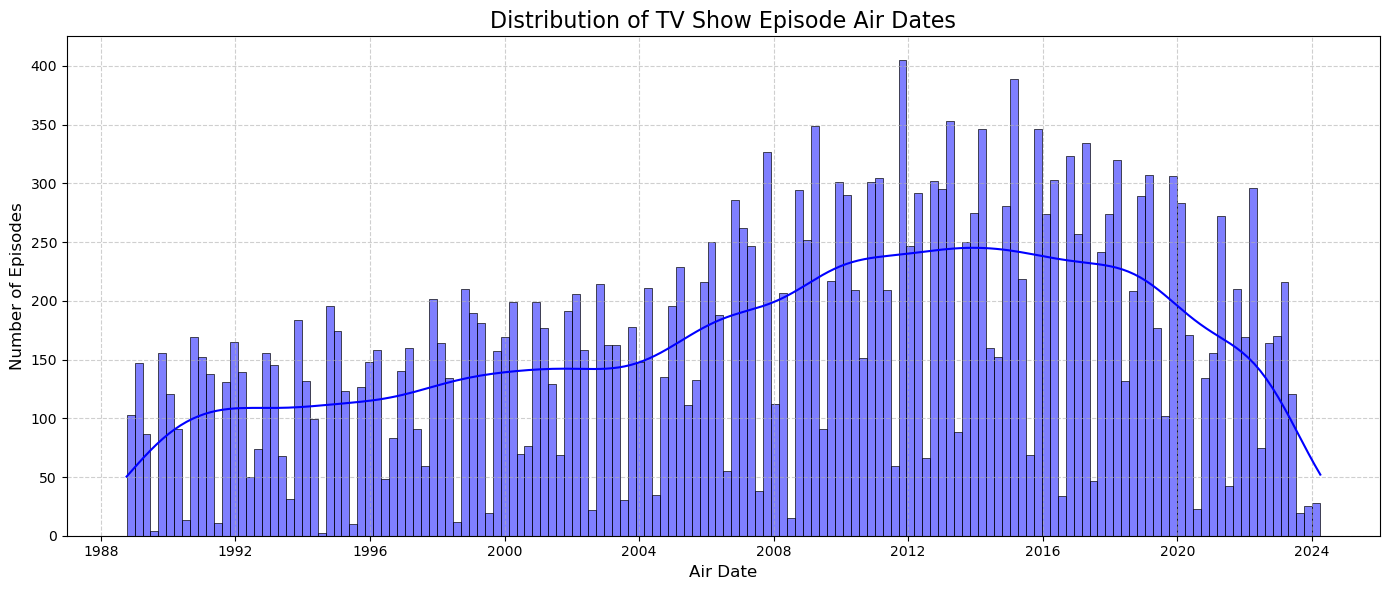

In [134]:
# Plot the distribution of air dates
plt.figure(figsize=(14, 6))
sns.histplot(data['Air Date'], bins=100, kde=True, color='blue')
plt.title('Distribution of TV Show Episode Air Dates', fontsize=16)
plt.xlabel('Air Date', fontsize=12)
plt.ylabel('Number of Episodes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

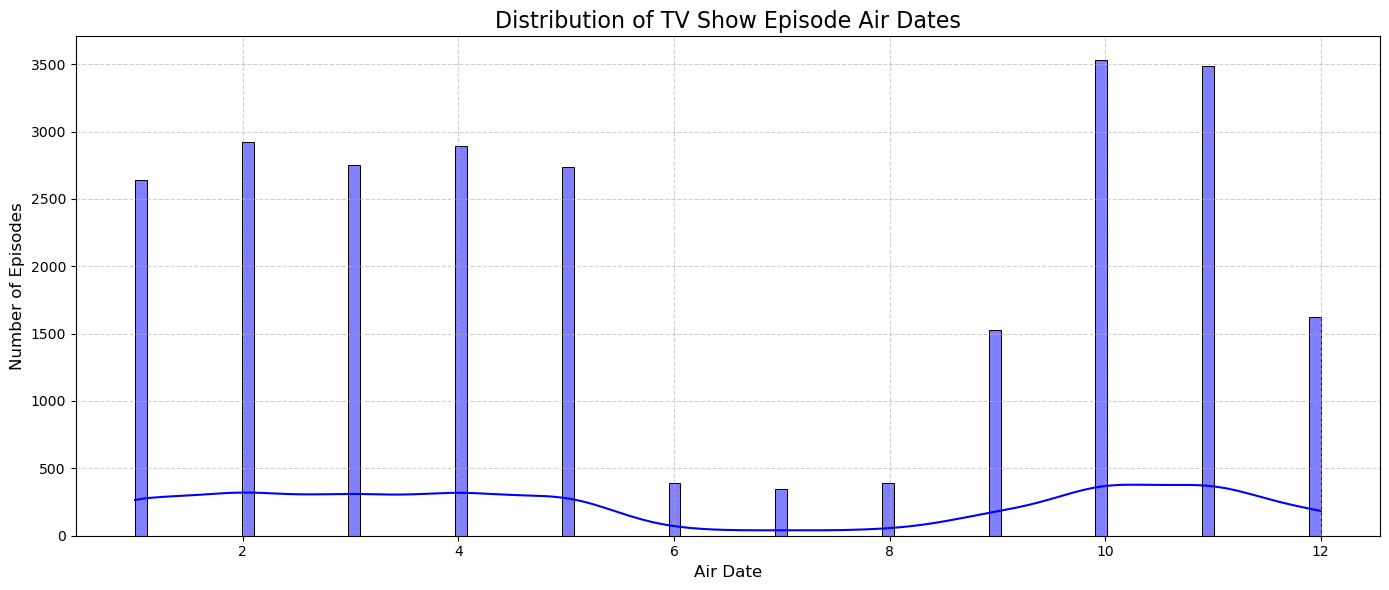

In [142]:
# Plot the distribution of air dates
plt.figure(figsize=(14, 6))
sns.histplot(data['month'], bins=100, kde=True, color='blue')
plt.title('Distribution of TV Show Episode Air Dates', fontsize=16)
plt.xlabel('Air Date', fontsize=12)
plt.ylabel('Number of Episodes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

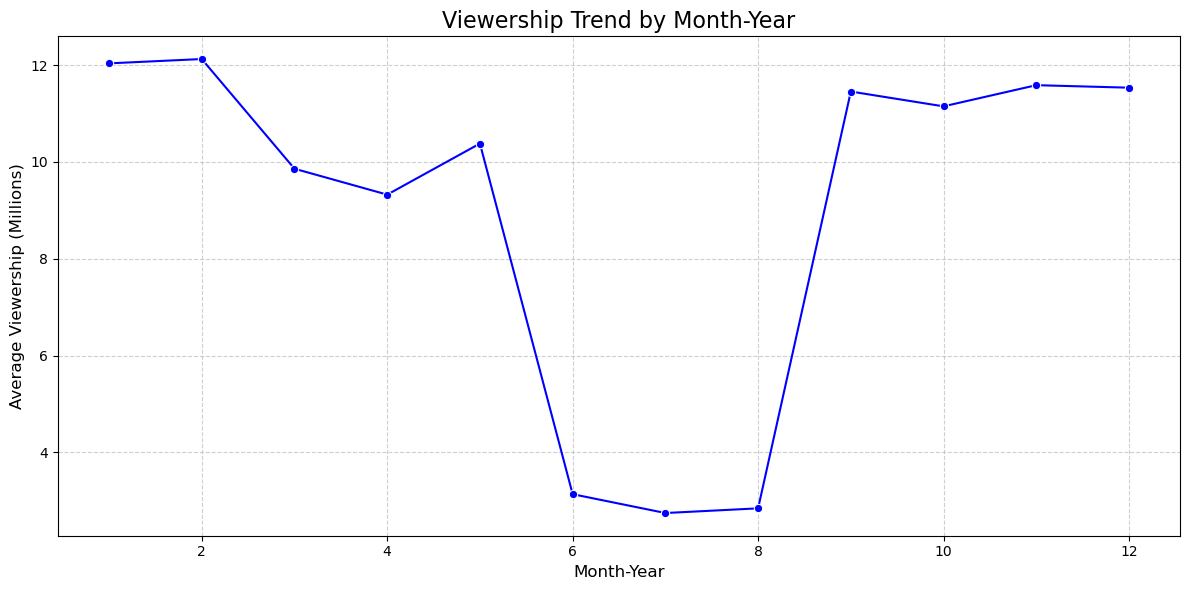

In [120]:
monthly_trends = data.groupby('month')['Viewership (millions)'].mean().reset_index()

# Line plot for monthly trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends, x='month', y='Viewership (millions)', marker='o', color='blue')
plt.title('Viewership Trend by Month', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Average Viewership (Millions)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [148]:
# Shows that air episodes during summer
data[data.season == 3].Show.unique()

array(['A Million Little Things', 'Adventure Time', 'Archer', 'Barry',
       'Better Call Saul', 'Big Love', 'Blindspot', 'Bones',
       'Breaking Bad', 'Buffy the Vampire Slayer', 'Code Black',
       'Crossing Jordan', 'Damages', 'Deadwood', 'Dexter', 'Elementary',
       'Empty Nest', 'Entourage', 'Euphoria', 'Family Guy', 'Fargo',
       'Futurama', 'Game of Thrones', 'Girls', 'Glee', 'Gravity Falls',
       "Grey's Anatomy", 'Hannibal', 'In Living Color', 'Insecure',
       'Instinct', "It's Always Sunny in Philadelphia", 'Just Shoot Me!',
       'Justified', 'Last Week Tonight with John Oliver', 'Law & Order',
       'Law & Order: Organized Crime', 'Life in Pieces', 'Living Single',
       'Mad Men', 'Manifest', 'Married... with Children', 'Medium',
       'Mr. Robot', 'New Amsterdam', 'Northern Exposure', 'Nurse Jackie',
       'Oz', 'Person of Interest', 'Pose', 'Regular Show',
       'Rick and Morty', 'Rome', 'Samantha Who?', 'Scrubs', 'Seinfeld',
       'Sex and the City', 

[0]
248 episodes


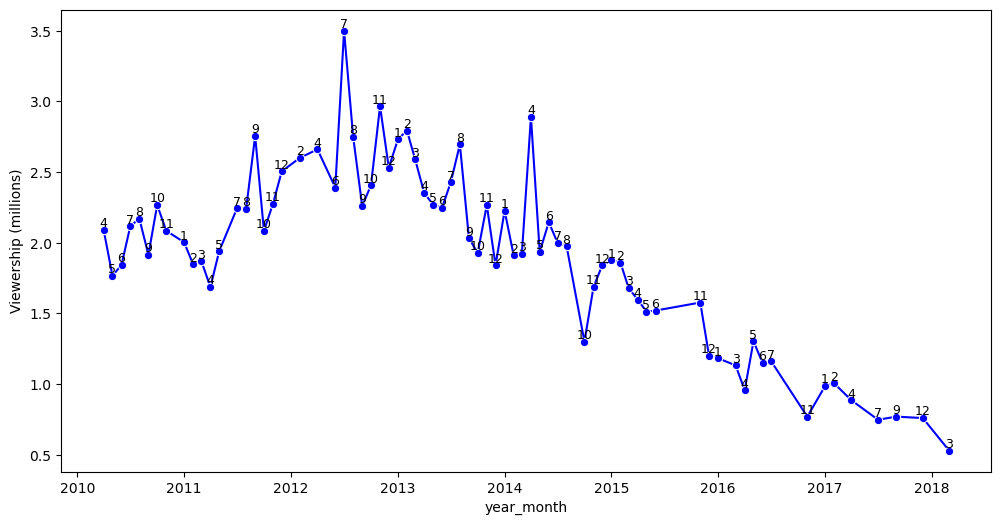

In [268]:
adventure_time_show = data[(data.Show == "Adventure Time")]
print(adventure_time_show.Cancelled.unique())
print(len(adventure_time_show.index), 'episodes')

adventure_time_data = adventure_time_show.groupby(['year_month','month'])['Viewership (millions)'].mean().reset_index()
# Convert year_month back to timestamp
adventure_time_data['year_month'] = adventure_time_data['year_month'].dt.to_timestamp()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=adventure_time_data, x='year_month', y='Viewership (millions)', marker='o', color='blue')
# Add labels to each point
for i in range(len(adventure_time_data)):
    x = adventure_time_data['year_month'].iloc[i]
    y = adventure_time_data['Viewership (millions)'].iloc[i]
    month = adventure_time_data['month'].iloc[i]
    plt.text(x, y, f'{month}', fontsize=9, ha='center', va='bottom', color='black')

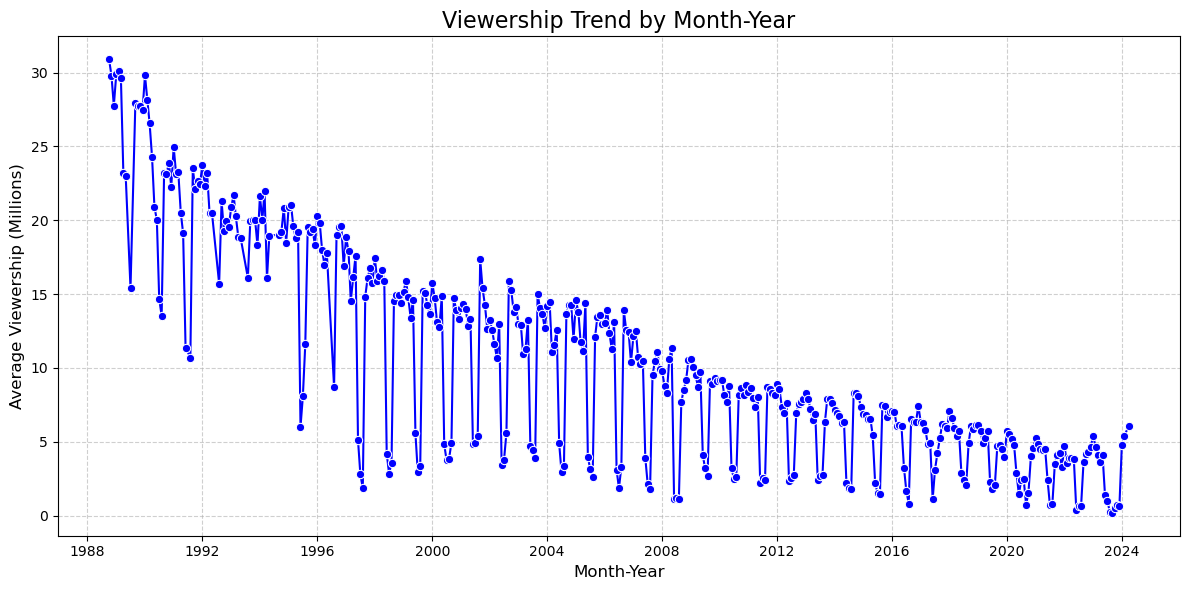

In [118]:
monthly_trends = data.groupby('year_month')['Viewership (millions)'].mean().reset_index()
monthly_trends['year_month'] = monthly_trends['year_month'].dt.to_timestamp()

# Line plot for monthly trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends, x='year_month', y='Viewership (millions)', marker='o', color='blue')
plt.title('Viewership Trend by Month-Year', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Average Viewership (Millions)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [139]:
print(data.groupby('Show').vw.std().sort_values(ascending = False).head(5))
data.groupby('Show').vw.std().sort_values(ascending = False).tail(5)

Show
ER                   9.140101
A Different World    8.138627
Roseanne             8.096697
The Cosby Show       7.948770
Empty Nest           7.538348
Name: vw, dtype: float64


Show
What We Do in the Shadows    0.106330
How To with John Wilson      0.103228
Succession                   0.101541
Yellowjackets                0.080540
Portlandia                   0.053403
Name: vw, dtype: float64

In [145]:
print(data.groupby(['Show','Cancelled','Genre']).vw.std().sort_values(ascending = False).head(10))

Show                            Cancelled  Genre            
ER                              0.0        Medical drama        9.140101
A Different World               0.0        Sitcom               8.138627
Roseanne                        1.0        Sitcom               8.096697
The Cosby Show                  0.0        Sitcom               7.948770
Empty Nest                      0.0        Sitcom               7.538348
Moonlighting                    1.0        Comedy drama         7.455715
Seinfeld                        0.0        Sitcom               7.387463
Home Improvement                0.0        Sitcom               7.326406
CSI: Crime Scene Investigation  0.0        Police procedural    7.091071
The Golden Girls                0.0        Sitcom               6.097400
Name: vw, dtype: float64


## Specific TV Show Evolution

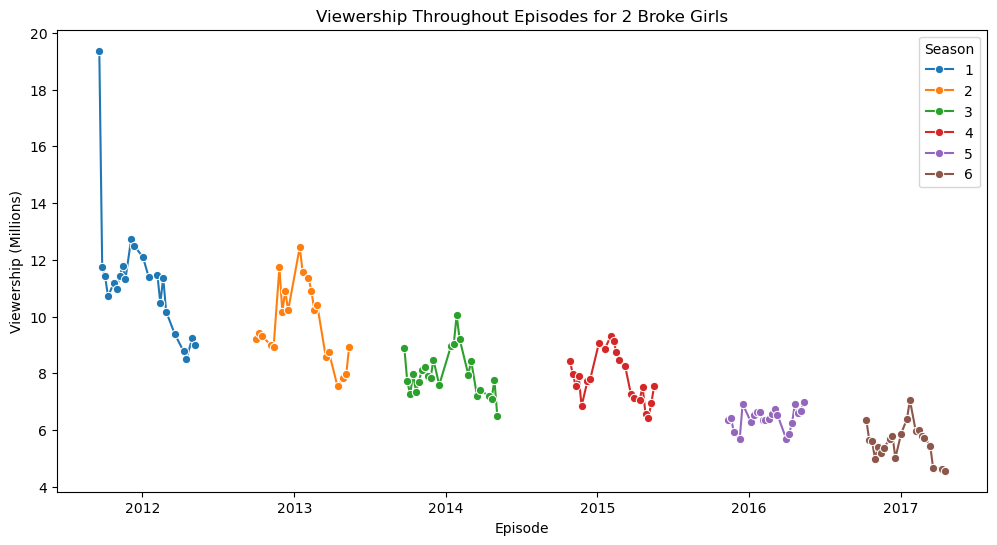

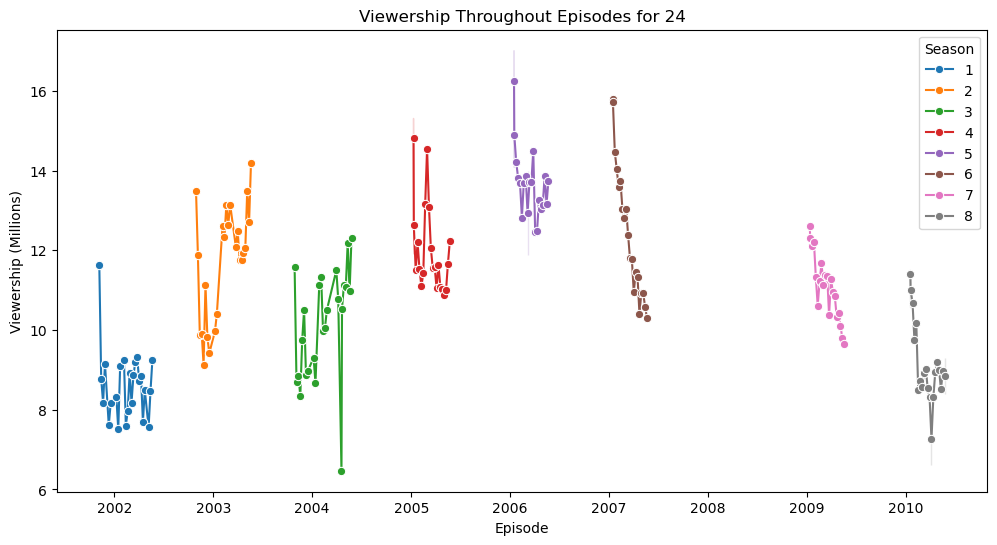

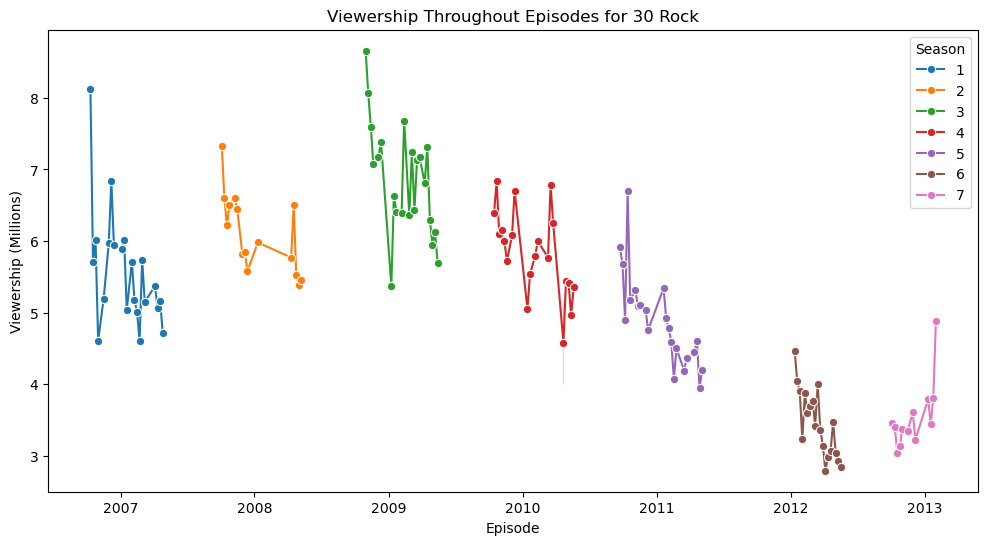

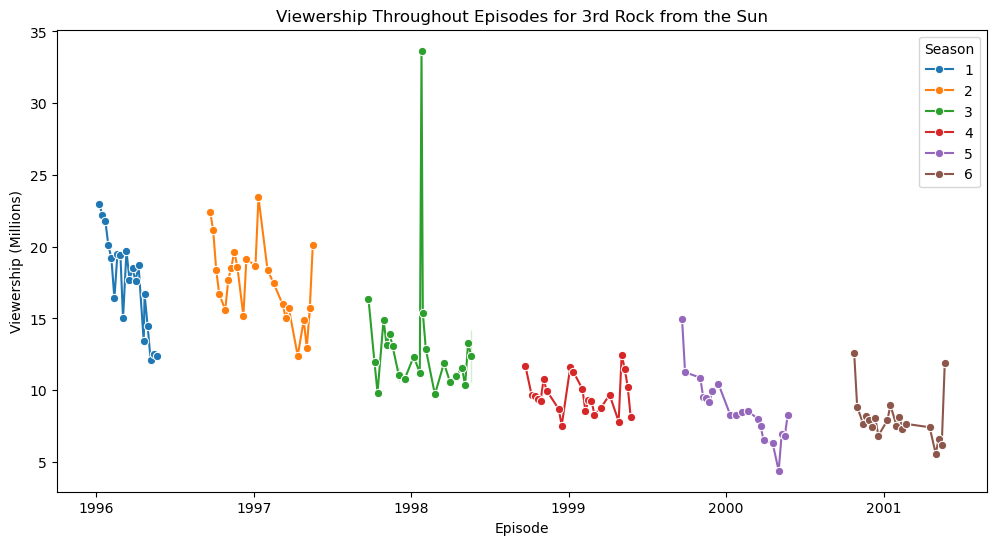

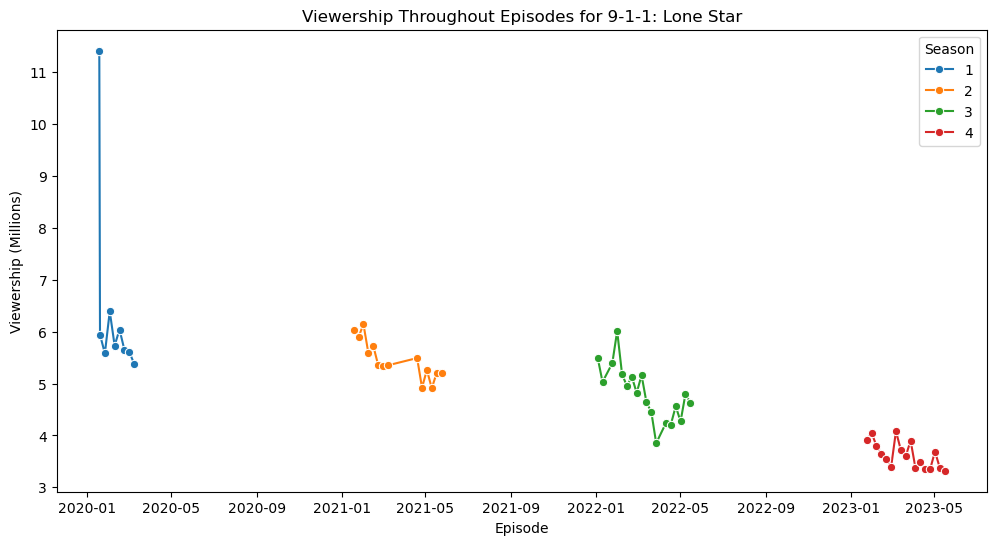

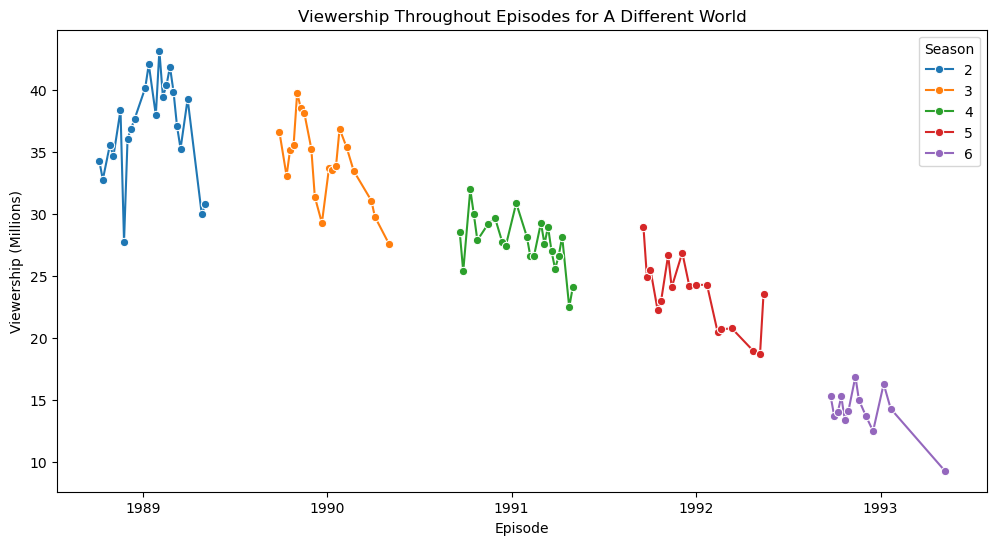

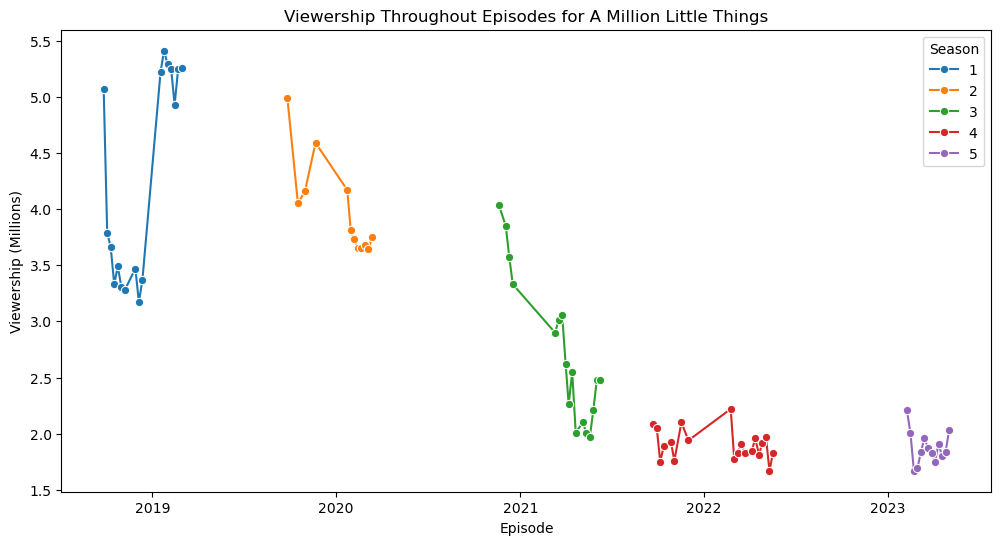

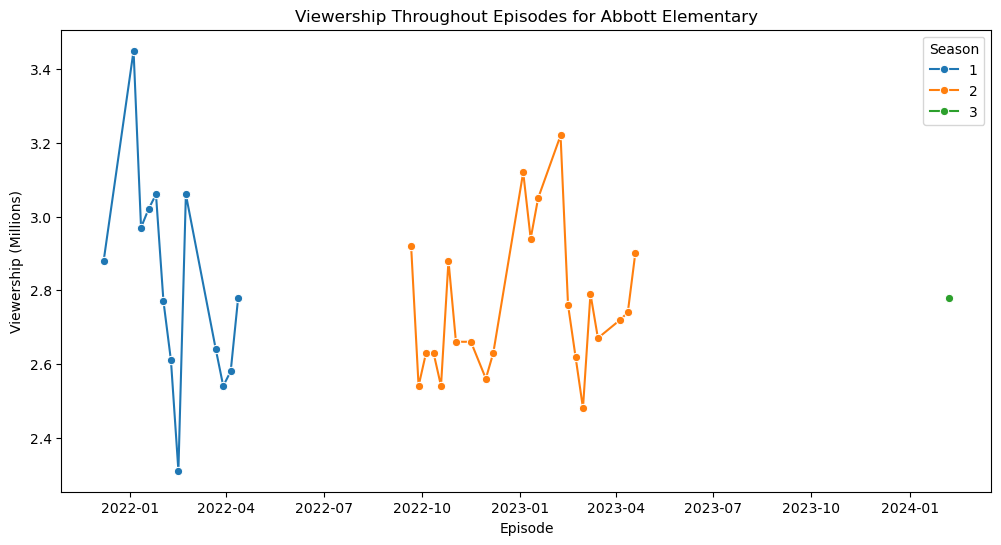

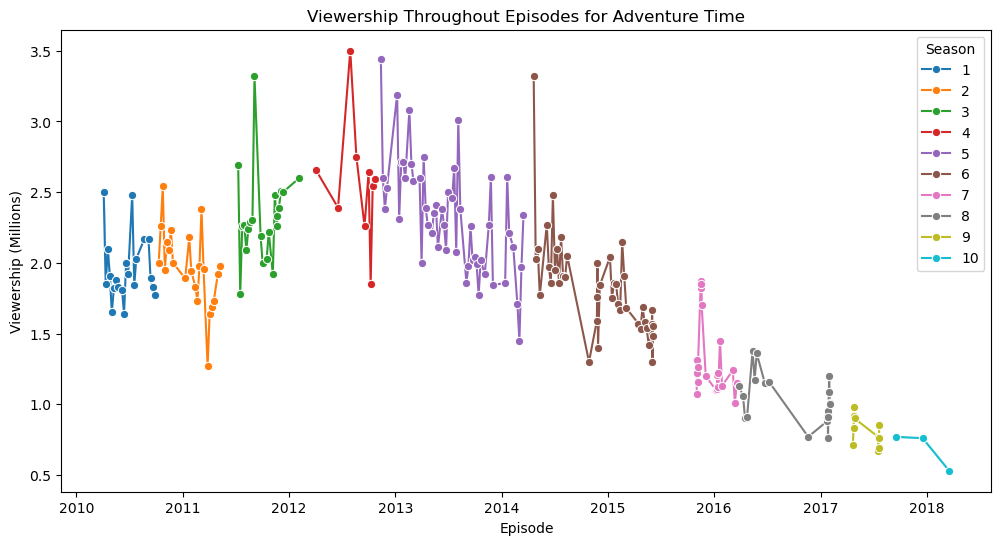

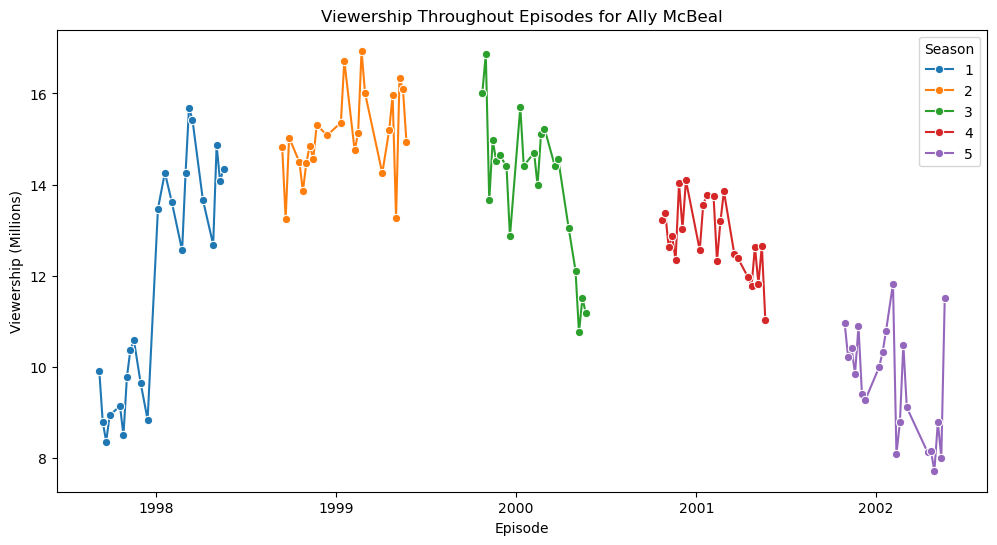

In [346]:
num_shows = 5
for specific_show in list(data.Show.unique())[:num_shows]:
    # Filter data for the specific show
    show_data = data[data['Show'] == specific_show]
    
    # Plot viewership by episode with season as a legend
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=show_data, x='Air Date', y='Viewership (millions)', hue='Season', marker='o', palette='tab10')
    
    # Add labels and title
    plt.title(f'Viewership Throughout Episodes for {specific_show}')
    plt.xlabel('Episode')
    plt.ylabel('Viewership (Millions)')
    plt.legend(title='Season')
    plt.show()

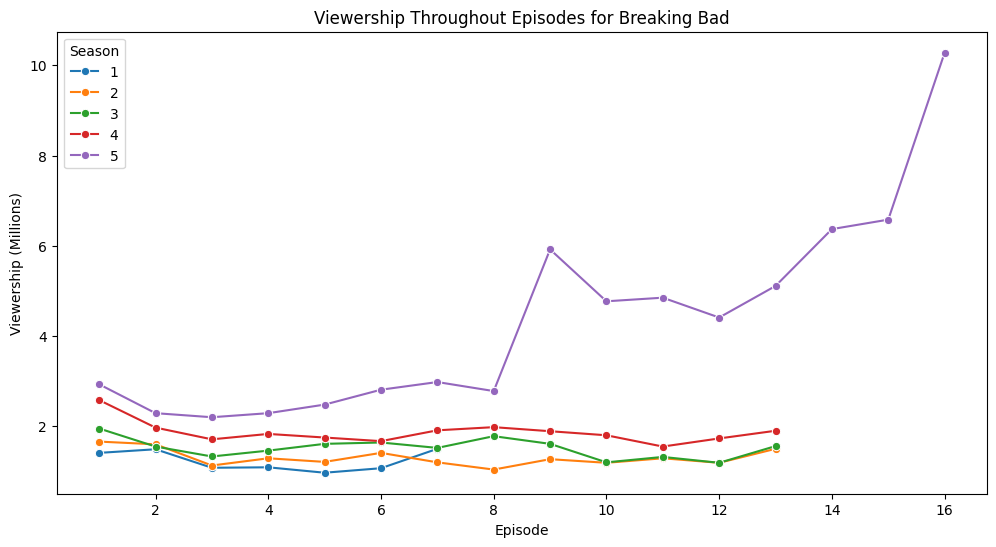

In [12]:
# Filter data for the specific show
specific_show = 'Breaking Bad'  # Replace with the name of the show you want to plot
show_data = data[data['Show'] == specific_show]

# Plot viewership by episode with season as a legend
plt.figure(figsize=(12, 6))
sns.lineplot(data=show_data, x='Episode', y='vw', hue='Season', marker='o', palette='tab10')

# Add labels and title
plt.title(f'Viewership Throughout Episodes for {specific_show}')
plt.xlabel('Episode')
plt.ylabel('Viewership (Millions)')
plt.legend(title='Season')
plt.show()

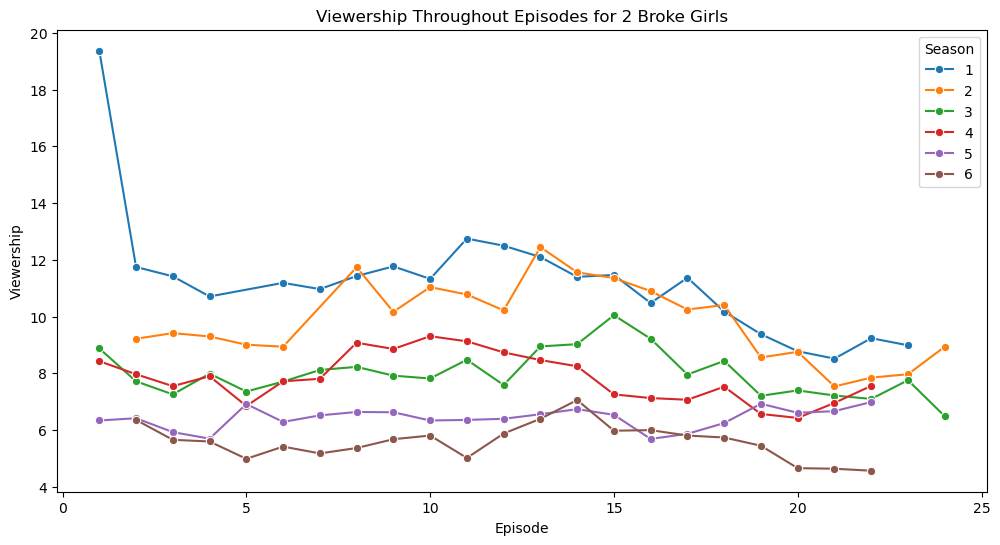

In [360]:
# Filter data for the specific show
specific_show = '2 Broke Girls'  # Replace with the name of the show you want to plot
show_data = data[data['Show'] == specific_show]

# Plot viewership by episode with season as a legend
plt.figure(figsize=(12, 6))
sns.lineplot(data=show_data, x='Episode', y='Viewership (millions)', hue='Season', marker='o', palette='tab10')

# Add labels and title
plt.title(f'Viewership Throughout Episodes for {specific_show}')
plt.xlabel('Episode')
plt.ylabel('Viewership')
plt.legend(title='Season')
plt.show()

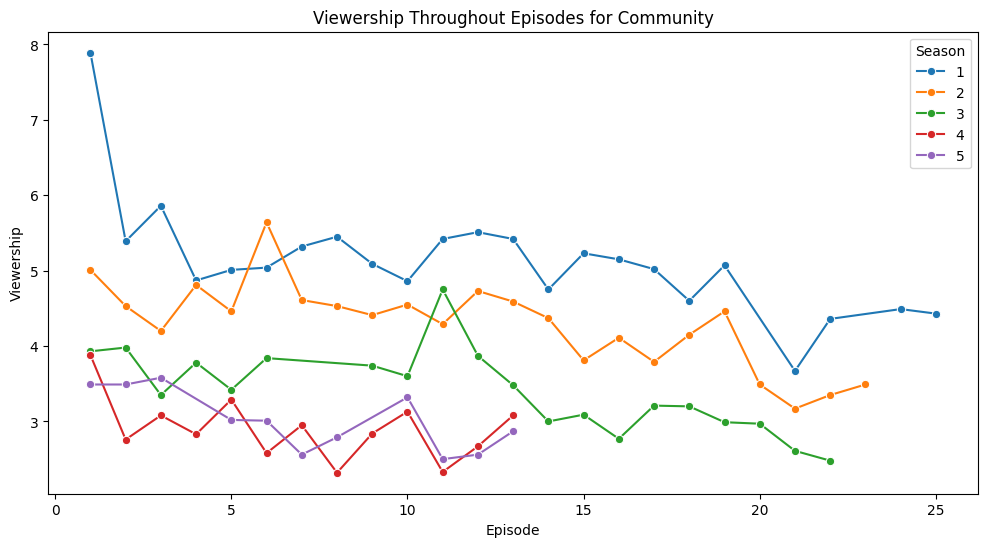

In [43]:
# Filter data for the specific show
specific_show = 'Community'  # Replace with the name of the show you want to plot
show_data = data[data['Show'] == specific_show]

# Plot viewership by episode with season as a legend
plt.figure(figsize=(12, 6))
sns.lineplot(data=show_data, x='Episode', y='vw', hue='Season', marker='o', palette='tab10')

# Add labels and title
plt.title(f'Viewership Throughout Episodes for {specific_show}')
plt.xlabel('Episode')
plt.ylabel('Viewership')
plt.legend(title='Season')
plt.show()

# Modeling

In [588]:
sitcom_data = data[data.Genre == 'Sitcom']

emotion_score_cols = ['SD_div_mean_2', 'SD_div_mean_3', 'SD_sum_1', 'SD_sum_2', 'SD_sum_3', 'SD_scaled_1', 'SD_scaled_2', 
                      'SD_scaled_3', 'Anger_1', 'Anger_2', 'Anger_3', 'Surprise_1', 'Surprise_2', 'Surprise_3', 'Disgust_1', 
                      'Disgust_2', 'Disgust_3', 'Sadness_1', 'Sadness_2', 'Sadness_3', 'Neutral_1', 'Neutral_2', 'Neutral_3', 
                      'Fear_1', 'Fear_2', 'Fear_3', 'Joy_1', 'Joy_2', 'Joy_3', 'Positive_1', 'Positive_2', 'Positive_3', 'Negative_1', 
                      'Negative_2', 'Negative_3', 'Engaged_1', 'Engaged_2', 'Engaged_3', 'Not engaged_1', 'Not engaged_2', 'Not engaged_3', 
                      'WC_1', 'WC_2', 'WC_3', 'Analytic_1', 'Analytic_2', 'Analytic_3', 'Clout_1', 'Clout_2', 'Clout_3', 'Authentic_1', 
                      'Authentic_2', 'Authentic_3', 'Tone_1', 'Tone_2', 'Tone_3', 'WPS_1', 'WPS_2', 'WPS_3', 'Sixltr_1', 'Sixltr_2', 
                      'Sixltr_3', 'Dic_1', 'Dic_2', 'Dic_3', 'Cogproc_1', 'Cogproc_2', 'Cogproc_3', 'Insight_1', 'Insight_2', 'Insight_3', 
                      'Cause_1', 'Cause_2', 'Cause_3', 'Discrep_1', 'Discrep_2', 'Discrep_3', 'Tentat_1', 'Tentat_2', 'Tentat_3', 
                      'Certain_1', 'Certain_2', 'Certain_3', 'Differ_1', 'Differ_2', 'Differ_3', 'Percept_1', 'Percept_2', 'Percept_3', 
                      'See_1', 'See_2', 'See_3', 'Hear_1', 'Hear_2', 'Hear_3', 'Feel_1', 'Feel_2', 'Feel_3', 'Drives_1', 'Drives_2', 
                      'Drives_3', 'Affiliation_1', 'Affiliation_2', 'Affiliation_3', 'Achieve_1', 'Achieve_2', 'Achieve_3', 'Power_1', 
                      'Power_2', 'Power_3', 'Reward_1', 'Reward_2', 'Reward_3', 'Risk_1', 'Risk_2', 'Risk_3', 'Relativ_1', 'Relativ_2', 
                      'Relativ_3', 'Motion_1', 'Motion_2', 'Motion_3', 'Space_1', 'Space_2', 'Space_3', 'Time_1', 'Time_2', 'Time_3']


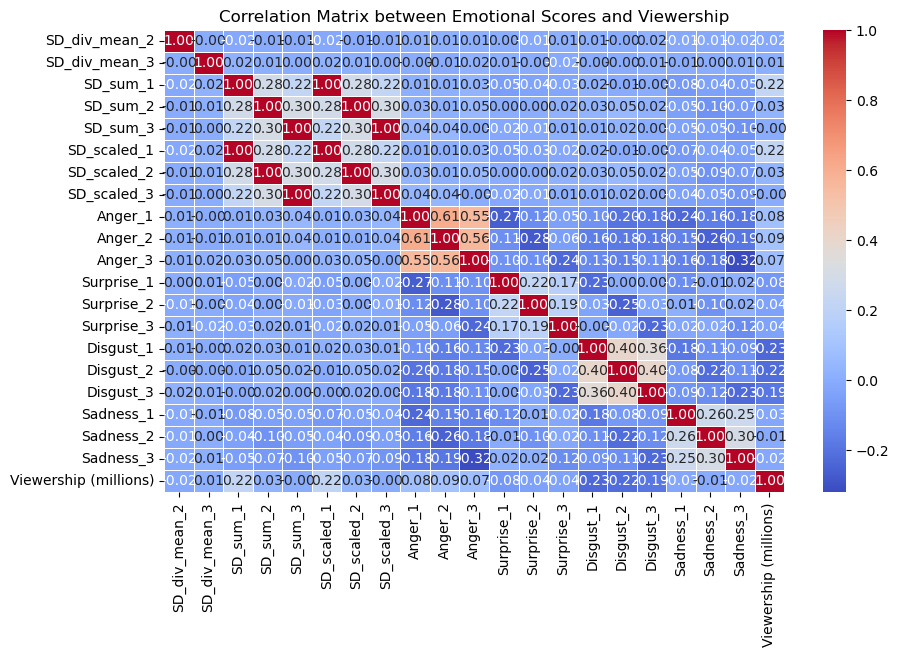

In [614]:
# Correlation matrix
corr_matrix = sitcom_data[emotion_score_cols[0:20] + ['Viewership (millions)']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix between Emotional Scores and Viewership')
plt.show()

## OLS

In [501]:
import statsmodels.api as sm
# Perform multiple linear regression
X = sitcom_data[emotion_score_cols]
X = sm.add_constant(X)  # Add constant term (intercept)
y = sitcom_data['Viewership (millions)']

model = sm.OLS(y, X).fit()  # Fit the regression model
print(model.summary())  # Display the summary of the regression

                              OLS Regression Results                             
Dep. Variable:     Viewership (millions)   R-squared:                       0.411
Model:                               OLS   Adj. R-squared:                  0.400
Method:                    Least Squares   F-statistic:                     37.32
Date:                   Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                           19:59:32   Log-Likelihood:                -22606.
No. Observations:                   6750   AIC:                         4.546e+04
Df Residuals:                       6625   BIC:                         4.631e+04
Df Model:                            124                                         
Covariance Type:               nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2

## XGBoost

In [590]:
model_data = sitcom_data[emotion_score_cols + ['Viewership (millions)', 'is_season_premiere', 'is_season_finale','vw_next','day_of_week']]

In [596]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [600]:
X = model_data.drop(columns=['Viewership (millions)'])
y = model_data['Viewership (millions)']

In [602]:
# Handle categorical variables (example: encoding)
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [604]:
# Initialize XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression
    n_estimators=100,  # Number of trees (can tune)
    learning_rate=0.1,  # Controls model complexity (can tune)
    max_depth=6,  # Max depth of trees (can tune)
    subsample=0.8,  # Fraction of data used for training each tree (can tune)
    colsample_bytree=0.8  # Fraction of features used for each tree (can tune)
)

In [606]:
# Train the model
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Figure size 1000x800 with 0 Axes>

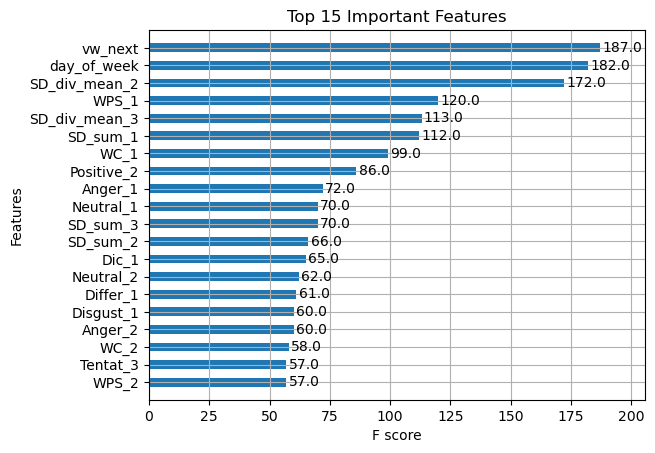

In [612]:
# Feature importance
import matplotlib.pyplot as plt
# Plot feature importance (top 15 features)
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # You can also use 'gain' or 'cover' depending on what you want to visualize
    max_num_features=20,  # Limit to top 15 features
    title="Top 15 Important Features",
    height=0.5  # Adjust the bar height for better readability
)
plt.show()

In [618]:
emotion_score_cols

['SD_div_mean_2',
 'SD_div_mean_3',
 'SD_sum_1',
 'SD_sum_2',
 'SD_sum_3',
 'SD_scaled_1',
 'SD_scaled_2',
 'SD_scaled_3',
 'Anger_1',
 'Anger_2',
 'Anger_3',
 'Surprise_1',
 'Surprise_2',
 'Surprise_3',
 'Disgust_1',
 'Disgust_2',
 'Disgust_3',
 'Sadness_1',
 'Sadness_2',
 'Sadness_3',
 'Neutral_1',
 'Neutral_2',
 'Neutral_3',
 'Fear_1',
 'Fear_2',
 'Fear_3',
 'Joy_1',
 'Joy_2',
 'Joy_3',
 'Positive_1',
 'Positive_2',
 'Positive_3',
 'Negative_1',
 'Negative_2',
 'Negative_3',
 'Engaged_1',
 'Engaged_2',
 'Engaged_3',
 'Not engaged_1',
 'Not engaged_2',
 'Not engaged_3',
 'WC_1',
 'WC_2',
 'WC_3',
 'Analytic_1',
 'Analytic_2',
 'Analytic_3',
 'Clout_1',
 'Clout_2',
 'Clout_3',
 'Authentic_1',
 'Authentic_2',
 'Authentic_3',
 'Tone_1',
 'Tone_2',
 'Tone_3',
 'WPS_1',
 'WPS_2',
 'WPS_3',
 'Sixltr_1',
 'Sixltr_2',
 'Sixltr_3',
 'Dic_1',
 'Dic_2',
 'Dic_3',
 'Cogproc_1',
 'Cogproc_2',
 'Cogproc_3',
 'Insight_1',
 'Insight_2',
 'Insight_3',
 'Cause_1',
 'Cause_2',
 'Cause_3',
 'Discrep_1',